In [9]:
import re
import time
from pathlib import Path

import librosa as lbr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
from tqdm.notebook import tqdm
tqdm.pandas()
from joblib import delayed, Parallel
from rich.progress import track

In [2]:
data_dir = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/data/original/training-dataset")
gen_dir  = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/generation")

In [30]:
def make_spectrogram(x):
    _, _, s = scipy.signal.spectrogram(x, fs=16000, window='hann', nperseg=256, noverlap=128, nfft=1024, return_onesided=True, scaling='spectrum', axis=-1, mode='magnitude')
    # s = lbr.stft(x, hop_length=128, win_length=256, n_fft=1024)
    # return lbr.power_to_db(np.abs(s)**2, amin=1e-4, ref=np.max)
    ref = 1
    amin = 1e-7
    np.log10(s / (ref*amin) + 1) / np.log10(10 / (ref*amin) + 1)
    return s

def make_melspectrogram(x):
    s = make_spectrogram(x)
    return lbr.feature.melspectrogram(S=s, sr=16000, n_mels=128, fmax=8000, fmin=500)

def make_spectrogram2(x):
    s = lbr.stft(x, hop_length=128, win_length=256, n_fft=1024)
    return np.log(1 + 100 * np.abs(s**2))  # Silvia's recipe

def make_mfcc(x):
    s = make_melspectrogram(x)
    s = lbr.feature.mfcc(S=s, sr=16000, hop_length=128, win_length=256, n_fft=1024, n_mfcc=13)
    d = lbr.feature.delta(s)
    return s
    
def preprocess(files, max_length, load=True, sr=16000, kind="mfcc"):
    @delayed
    def load(f):
        if load:
            y = lbr.load(f, sr=sr)[0]

        else:
            y = f
        y = lbr.util.normalize(y)
        # sos = scipy.signal.butter(5, 500, btype='high', output='sos', fs=sr)
        # y = scipy.signal.sosfiltfilt(sos, y)
        if kind == "mfcc":
            return make_mfcc(y[:max_length])
        elif kind == "spec":
            return make_spectrogram(y[:max_length])
        elif kind == "spec2":
            return make_spectrogram2(y[:max_length])
        elif kind == "mel":
            return make_melspectrogram(y[:max_length])
        else:
            raise NotImplementedError(kind)
    
    results = Parallel(n_jobs=-1)(load(f) for f in files)

    return results

In [31]:
sr = 16000
max_length = round(sr * 0.3)

In [37]:
files = list(data_dir.rglob("**/*.wav"))

data_table = {
    "file": files,
    "label": [f.parent.name for f in files],
    "sr": 16000,
    "kind": "real",
}

rdf = pd.DataFrame(data_table)

#rdf["s"] = preprocess(track(rdf.file), max_length, kind="mfcc")
rdf["spec"] = preprocess(tqdm(rdf.file), max_length, kind="spec2")

rdf = rdf.sort_values(by=["label", "file"]).reset_index(drop=True)

rdf["y"] = rdf["label"]

display(rdf.head())
display(rdf.info())

  0%|          | 0/16000 [00:00<?, ?it/s]

,file,label,sr,kind,spec,y
0,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[8.3446474e-07, 6.2821324e-05, 1.7046781e-05,...",A
1,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.0012387707, 1.0403626, 0.9431223, 0.0, 0.0...",A
2,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[2.1219028e-05, 2.7775377e-05, 1.19209275e-07...",A
3,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[0.00016366097, 0.00011753345, 2.1219028e-05,...",A
4,/run/media/nathan/Nathan4T/Nathan-canarygan/da...,A,16000,real,"[[1.919251e-05, 4.76836e-06, 2.6583317e-05, 0....",A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    16000 non-null  object
 1   label   16000 non-null  object
 2   sr      16000 non-null  int64 
 3   kind    16000 non-null  object
 4   spec    16000 non-null  object
 5   y       16000 non-null  object
dtypes: int64(1), object(5)
memory usage: 750.1+ KB


None

In [38]:
labels = sorted(rdf.label.unique().tolist())
colors = {l: sns.color_palette("tab20")[i] for i, l in enumerate(labels + ["X"])}

In [39]:
mf = [np.mean(rdf.query("label==@lbl").spec.values, axis=0) for lbl in labels]
mf = np.dstack(mf)

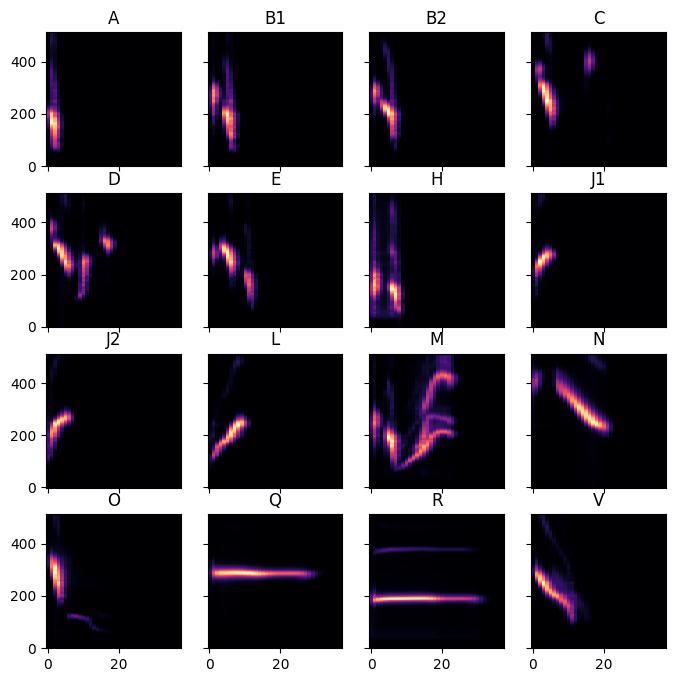

In [44]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, lbl in enumerate(labels):
    ax = axs[i]
    im = ax.imshow(
        np.mean(rdf.query("label==@lbl").spec.values, axis=0), 
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="magma",
    )
    ax.set_title(lbl)

plt.savefig("../reports/mean_spec_real.pdf", bbox_inches="tight")